In [329]:
import numpy as np
import pandas as pd
from numba import njit, jit

from math import log, sqrt, pi, exp, erf
from scipy.stats import norm

from matplotlib import pyplot as plt
from tqdm import tqdm
from time import perf_counter
import gc

""" API requirements """
import pandas as pd
import yfinance as yf

""" Plt font size """
plt.rcParams['font.size'] = '13'

# Calculate T

In [330]:
import pandas_market_calendars as mcal
import datetime as dt
# Create a calendar
nyse = mcal.get_calendar('NYSE')

# Show available calendars
# print(mcal.get_calendar_names())
# early = nyse.schedule(start_date='2022-03-07', end_date='2022-09-16')       # For fixed initial date calculator
early = nyse.schedule(start_date=dt.datetime.now(), end_date='2022-09-16')
T = early.shape[0]

print(f'Expiration Date = {"2022-09-16"}')
print(f"Trading Days until expiration = {T} / 252") ; T = T / 252
print(f"T = {T}")

Expiration Date = 2022-09-16
Trading Days until expiration = 134 / 252
T = 0.5317460317460317


# Calculate r from R

In [331]:
""" Treasury Bill """
# t_bill = yf.Tickers(tickers="TMUBMUSD06M") #("AAPL") # TMUBMUSD06M
# t_bill.history()

R = 0.00674
r = np.log(1 + R)

print(f"R    = {R}")
print(f'CC R = {r:.5f}')

R    = 0.00674
CC R = 0.00672


# Calculate S0
## Get Historical Stock Data from Yahoo Finance

In [332]:
aapl = yf.Ticker("AAPL")

In [333]:
# get historical market data
hist = aapl.history(period="max")
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12,0.100326,0.100762,0.100326,0.100326,469033600,0.0,0.0
1980-12-15,0.095528,0.095528,0.095092,0.095092,175884800,0.0,0.0
1980-12-16,0.088548,0.088548,0.088112,0.088112,105728000,0.0,0.0
1980-12-17,0.090293,0.090729,0.090293,0.090293,86441600,0.0,0.0
1980-12-18,0.092911,0.093347,0.092911,0.092911,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2022-03-01,164.699997,166.600006,161.970001,163.199997,83474400,0.0,0.0
2022-03-02,164.389999,167.360001,162.949997,166.559998,79724800,0.0,0.0
2022-03-03,168.470001,168.910004,165.550003,166.229996,76678400,0.0,0.0


## Calculate S0 from the last Closing Price - daily Interval

In [334]:
""" Closing Price - S0 """
S0 = hist.iloc[-1].Close ; print(f'S0 = {S0:.5f}')

S0 = 159.30000


# Calculate sigma - Realized/Historical Volatility

In [335]:
from numpy import log as ln
""" Std of the log of daily returns """
hist['prChange'] = hist.Close.pct_change()
hist['log_ret'] = np.log(1 + hist.prChange)

""" Get volatility of last 6 months """
realized_volatility_last_6_months = hist.loc[hist.index > np.datetime64('2021-09-01')].log_ret.std(ddof=1)
print(f'Realized volatility of the last 6 months  = {realized_volatility_last_6_months:.9f}')


""" Parkinson Volatility Model """
sum_squared_log_HL = ((np.log((hist.High / hist.Low)))**2 ).loc[hist.index > np.datetime64('2021-09-01')]
# print(sum_squared_log_HL)
# print(f'N = {sum_squared_log_HL.shape[0]}  ->  df = {{{sum_squared_log_HL.shape[0] - 1}}}')
parkinson_historical_volatility_last_6_months = np.sqrt( 1/(4*(sum_squared_log_HL.shape[0]-1)*np.log(2)) * sum_squared_log_HL.sum() )
print(f'Parkinson volatility of the last 6 months = {parkinson_historical_volatility_last_6_months:.9f}')

""" Rogers and Satchell Volatility Function """
data = hist.loc[hist.index > np.datetime64('2021-09-01')]
daily_rs_sqr_vol_v1 = (ln(data.High/data.Open)*( ln(data.High/data.Open) - ln(data.Close/data.Open))) \
         + ln(data.Low/data.Open)*( ln(data.Low/data.Open)  - ln(data.Close/data.Open))
daily_rs_sqr_vol_v2 = (ln(data.High/data.Open)*(ln(data.High/data.Close))) \
         + ln(data.Low/data.Open)*( ln(data.Low/data.Close))
rs_vol1 = np.sqrt(daily_rs_sqr_vol_v1.mean())
rs_vol2 = np.sqrt(daily_rs_sqr_vol_v1.mean())

print(f'V_rs (v1) = {rs_vol1}')
print(f'V_rs (v2) = {rs_vol2}')

Realized volatility of the last 6 months  = 0.016209461
Parkinson volatility of the last 6 months = 0.014732770
V_rs (v1) = 0.014348704833509262
V_rs (v2) = 0.014348704833509262


# Calculate K
## Get dates for options' expiration date - and find option closer to the current

In [336]:
""" Available Dates """
options_list = aapl.options
options_list

('2022-03-11',
 '2022-03-18',
 '2022-03-25',
 '2022-04-01',
 '2022-04-08',
 '2022-04-14',
 '2022-04-22',
 '2022-05-20',
 '2022-06-17',
 '2022-07-15',
 '2022-08-19',
 '2022-09-16',
 '2022-10-21',
 '2022-11-18',
 '2023-01-20',
 '2023-03-17',
 '2023-06-16',
 '2023-09-15',
 '2024-01-19')

In [337]:
""" Put Options ~ 6 Months from now """
opt = aapl.option_chain(options_list[ options_list == "2022-09-16"])
opt_puts = opt.puts
opt_puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL220311P00105000,2022-03-04 20:35:57+00:00,105.0,0.01,0.0,0.0,0.0,0.0,54,1033,0.500005,False,REGULAR,USD
1,AAPL220311P00110000,2022-03-07 20:03:11+00:00,110.0,0.01,0.0,0.0,0.0,0.0,490,3733,0.500005,False,REGULAR,USD
2,AAPL220311P00115000,2022-03-07 20:10:55+00:00,115.0,0.01,0.0,0.0,0.0,0.0,173,1940,0.500005,False,REGULAR,USD
3,AAPL220311P00120000,2022-03-07 19:39:57+00:00,120.0,0.01,0.0,0.0,0.0,0.0,735,1273,0.500005,False,REGULAR,USD
4,AAPL220311P00125000,2022-03-07 20:59:58+00:00,125.0,0.02,0.0,0.0,0.0,0.0,106,2768,0.500005,False,REGULAR,USD
5,AAPL220311P00130000,2022-03-07 20:45:49+00:00,130.0,0.03,0.0,0.0,0.0,0.0,1006,4053,0.500005,False,REGULAR,USD
6,AAPL220311P00134000,2022-03-07 20:52:58+00:00,134.0,0.04,0.0,0.0,0.0,0.0,365,802,0.500005,False,REGULAR,USD
7,AAPL220311P00135000,2022-03-07 20:54:51+00:00,135.0,0.04,0.0,0.0,0.0,0.0,1383,4101,0.250007,False,REGULAR,USD
8,AAPL220311P00136000,2022-03-07 20:52:08+00:00,136.0,0.05,0.0,0.0,0.0,0.0,215,258,0.250007,False,REGULAR,USD
9,AAPL220311P00137000,2022-03-07 19:51:24+00:00,137.0,0.05,0.0,0.0,0.0,0.0,2109,2191,0.250007,False,REGULAR,USD


In [338]:
""" From that list, puts ~ at the money """
_tempdf = opt_puts[opt_puts.inTheMoney == True]
option_at_the_money = _tempdf.iloc[(_tempdf['strike'] - S0 ).abs().argsort()[:1]]

K  = option_at_the_money.strike.iloc[0]  ;   print(f"K  = {K} EUR")
P0 = option_at_the_money.lastPrice.iloc[0]  ;   print(f"P0 = {P0}  EUR -> Asking Price")
option_at_the_money

K  = 160.0 EUR
P0 = 3.15  EUR -> Asking Price


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
26,AAPL220311P00160000,2022-03-07 20:59:57+00:00,160.0,3.15,0.0,0.0,0.0,0.0,71465,17346,0.00001,True,REGULAR,USD


# Part 2

-------------------------------------------------------------------------------------------------------------------------------
## Black Sholes Analytical Formula

In [339]:
@njit
def bs_put(S, K, T, r, sigma):
    d1 = (log(S/K)+(r+sigma**2/2.)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)

    """ negative in front - negative in front of d1 """
    D = - (1.0 + erf(-d1 / sqrt(2.0))) / 2.0
    V = S*D + K*exp(-r*T)* (1.0 + erf(-d2 / sqrt(2.0))) / 2.0

    return V

In [340]:
black_sholes_put_value = bs_put(S0, K, T, r, rs_vol2)
print("------ BS Put Evaluation ------")
print(f'Option Value with Black-Scholes Formula = {black_sholes_put_value}')

------ BS Put Evaluation ------
Option Value with Black-Scholes Formula = 0.7319777976251771


## Binomial Tree - Option Valuation

In [341]:
@njit
def option_valuation_bt(T, r , K, vol, N, S ,type="C", american=False):
    dt = T / N
    u = np.exp(vol * np.sqrt(dt)) # TODO
    d = np.exp(-vol * np.sqrt(dt)) # TODO
    p = (np.exp(r*dt) - d)/(u - d) # TODO
    """ ----- Build the Tree ----- """
    tree = np.zeros((N + 1, N + 1))
    # Iterate over the lower triangle
    for i in np.arange(N + 1): # iterate over rows
        for j in np.arange(i + 1): # iterate over columns
            # Hint: express each cell as a combination of up and down moves
            # tree[i, j] = max(tree[i, j], S * d ** (i-j) * u ** (j)) # TODO
            tree[i, j] = S * d ** (i-j) * u ** (j) # TODO

    """ ----- Calculate the Option Value ----- """
    columns = tree.shape[1]
    rows = tree.shape[0]

    # Walk backward , we start in last row of the matrix

    # Add the payoff function in the last row
    for c in np.arange(columns):
        _S = tree[rows-1, c] # value in the matrix
        if type == "C": tree[rows-1, c] = max(0, _S - K) # TODO
        else: tree[rows-1, c] = max(0, K- _S) # TODO
    # print( tree.astype(int) )

    # For all other rows , we need to combine from previous rows
    # We walk backwards , from the last row to the first row
    for i in np.arange(rows-1)[::-1]:
        for j in np.arange(i + 1):
            down = tree[i+1, j]
            up = tree[i + 1, j + 1]
            if type == "C":
                if american:    tree[i , j ] = max(tree[i , j ]-K, (np.exp(-r*dt)) * (p * up + (1 - p) * down)) # TODO
                else:   tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) # TODO
            else:
                if american:    tree[i , j ] = max(K-tree[i , j ], (np.exp(-r*dt)) * (p * up + (1 - p) * down)) # TODO
                else:   tree[i , j ] = (np.exp(-r*dt)) * (p * up + (1 - p) * down) # TODO
    # print(tree)
    V = tree[0,0]
    """ Greeks """
    D = (tree[1, 1] - tree[1, 0])/(S * (u - d))
    return V

In [342]:
N = 10_000

# tree = buildTree(S, sigma, T, N)
V_bt = option_valuation_bt(T, r , K, rs_vol2, N, S0, type="P")
print(f'Option Value with N({N}) steps = {V_bt:.5f}')
# print(f'Delta with N({N}) steps        = {D_bt:.5f}')

Option Value with N(10000) steps = 0.73196


## Calculate/Plot Option Value Convergence with N (steps)

In [361]:
NN = 10_000 ;   size = 100
values = np.zeros((size, 3))
for n in tqdm(np.append(np.logspace(1, np.log10(NN), size, base=10, dtype=int), 50)): #  _starting_n, NN)):
    # print(n)
    _st = perf_counter()
    V_bt = option_valuation_bt(T, r , K, rs_vol2, n, S0, type="P")
    values[size-1] = [n, V_bt, perf_counter() - _st]
    size -= 1
values = values[::-1]

100%|██████████| 101/101 [00:05<00:00, 19.58it/s]


,Binary Tree,Execution Time,Black Scholes,|Difference|
10,0.740784,0.000007,0.731978,0.008806
11,0.731621,0.000005,0.731978,0.000357
12,0.736551,0.000005,0.731978,0.004573
13,0.735117,0.000005,0.731978,0.003139
14,0.733053,0.000005,0.731978,0.001075
...,...,...,...,...
7564,0.731980,0.364835,0.731978,0.000002
8111,0.731990,0.427138,0.731978,0.000012
8697,0.731959,0.471722,0.731978,0.000018
9326,0.731981,0.606043,0.731978,0.000003


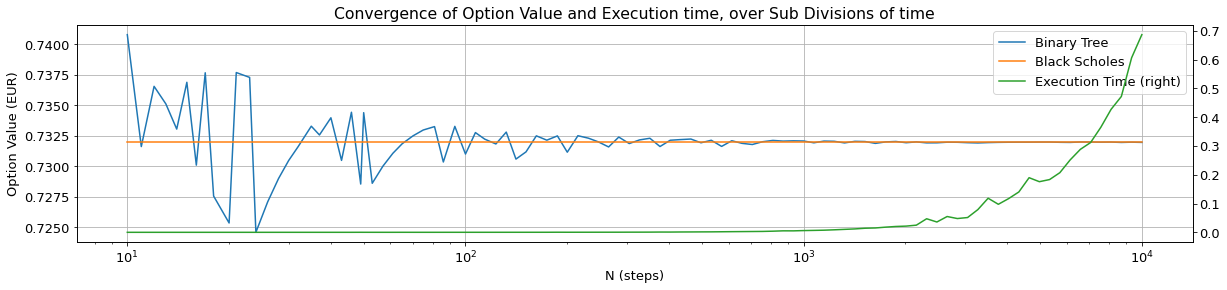

In [362]:
_results_convergence_df = pd.DataFrame(values[:, 1:], columns=['Binary Tree', 'Execution Time'] , index=values[:, 0].astype(int)).sort_index()
_results_convergence_df["Black Scholes"] = black_sholes_put_value
_results_convergence_df["|Difference|"] = abs(_results_convergence_df[['Binary Tree']] - black_sholes_put_value)

_results_convergence_df[['Binary Tree', 'Black Scholes', 'Execution Time']].plot(figsize=(20,4), xlabel='N (steps)', ylabel='Option Value (EUR)', mark_right=True,
                              title='Convergence of Option Value and Execution time, over Sub Divisions of time', grid=True, logx=True,
                              secondary_y='Execution Time' )
_results_convergence_df

## Plot Relative to Time - American vs European

In [345]:
N = 1_000   ;   size = 100  ;   values = np.zeros((size, 3))
for _T in tqdm(np.linspace(1/252, 5, num=size)):
    _V_bt_european = option_valuation_bt(_T, r , K, rs_vol2, N, S0, type="P")
    _V_bt_american = option_valuation_bt(_T, r , K, rs_vol2, N, S0, type="P", american=True)
    values[size-1] = [_T, _V_bt_european, _V_bt_american]
    size -= 1
values = values[::-1]
values

100%|██████████| 100/100 [00:01<00:00, 74.07it/s]


array([[3.96825397e-03, 6.95732016e-01, 6.99996948e-01],
       [5.44332211e-02, 6.71451020e-01, 7.02341467e-01],
       [1.04898188e-01, 6.77692223e-01, 7.19721799e-01],
       [1.55363155e-01, 6.87646575e-01, 7.40090031e-01],
       [2.05828122e-01, 6.97130665e-01, 7.59562318e-01],
       [2.56293090e-01, 7.05440721e-01, 7.77555731e-01],
       [3.06758057e-01, 7.12465981e-01, 7.94044639e-01],
       [3.57223024e-01, 7.18276994e-01, 8.09179451e-01],
       [4.07687991e-01, 7.23408429e-01, 8.23248519e-01],
       [4.58152958e-01, 7.27332253e-01, 8.36168682e-01],
       [5.08617925e-01, 7.30710953e-01, 8.48242823e-01],
       [5.59082892e-01, 7.33451360e-01, 8.59548277e-01],
       [6.09547860e-01, 7.35369057e-01, 8.70050111e-01],
       [6.60012827e-01, 7.36742050e-01, 8.79886327e-01],
       [7.10477794e-01, 7.38021671e-01, 8.89290522e-01],
       [7.60942761e-01, 7.38753499e-01, 8.98135519e-01],
       [8.11407728e-01, 7.39005597e-01, 9.06472734e-01],
       [8.61872695e-01, 7.38835

<AxesSubplot:title={'center':'European vs American Put Over Time, with fixed R, K'}, xlabel='T (Years)', ylabel='Option Value'>

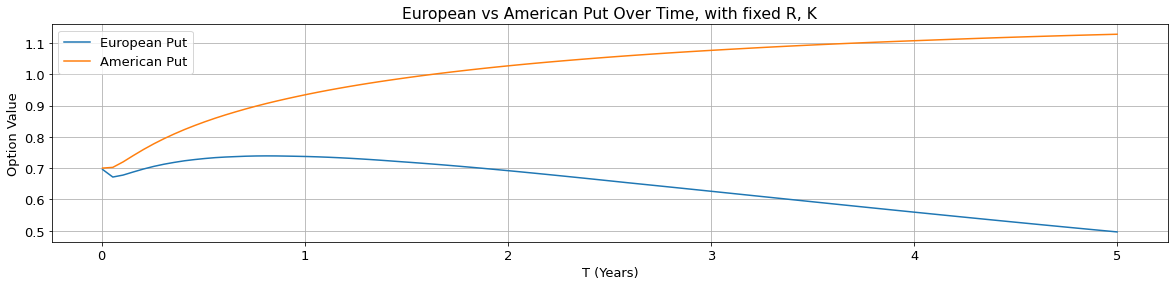

In [346]:
_results_df = pd.DataFrame(values[:, 1:], columns=['European Put', 'American Put'] , index=values[:, 0]).sort_index()
_results_df

_results_df[['European Put', 'American Put']].plot(figsize=(20,4), xlabel='T (Years)', ylabel='Option Value',
                              title='European vs American Put Over Time, with fixed R, K', grid=True)

## Plot Option Value Relative to N - American vs European

In [347]:
size = 200  ;   values = np.zeros((size, 3))
for n in tqdm(np.logspace(1, 4, num=size, base=10, dtype=int)):
    _V_bt_european = option_valuation_bt(T, r , K, rs_vol2, n, S0, type="P")
    _V_bt_american = option_valuation_bt(T, r , K, rs_vol2, n, S0, type="P", american=True)
    values[size-1] = [n, _V_bt_european, _V_bt_american]
    size -= 1
values = values[::-1]
values

100%|██████████| 200/200 [00:19<00:00, 10.36it/s]  


array([[1.00000000e+01, 7.40783924e-01, 8.52668887e-01],
       [1.00000000e+01, 7.40783924e-01, 8.52668887e-01],
       [1.00000000e+01, 7.40783924e-01, 8.52668887e-01],
       [1.10000000e+01, 7.31621118e-01, 8.54386234e-01],
       [1.10000000e+01, 7.31621118e-01, 8.54386234e-01],
       [1.10000000e+01, 7.31621118e-01, 8.54386234e-01],
       [1.20000000e+01, 7.36551109e-01, 8.52364489e-01],
       [1.20000000e+01, 7.36551109e-01, 8.52364489e-01],
       [1.30000000e+01, 7.35117256e-01, 8.56558839e-01],
       [1.30000000e+01, 7.35117256e-01, 8.56558839e-01],
       [1.40000000e+01, 7.33053066e-01, 8.52325907e-01],
       [1.40000000e+01, 7.33053066e-01, 8.52325907e-01],
       [1.50000000e+01, 7.36883409e-01, 8.57506623e-01],
       [1.50000000e+01, 7.36883409e-01, 8.57506623e-01],
       [1.60000000e+01, 7.30101932e-01, 8.52166930e-01],
       [1.60000000e+01, 7.30101932e-01, 8.52166930e-01],
       [1.70000000e+01, 7.37662609e-01, 8.57585384e-01],
       [1.80000000e+01, 7.27569

European Put     0.731963
American Put     0.853478
% Difference   -14.652224
Name: 10000.0, dtype: float64

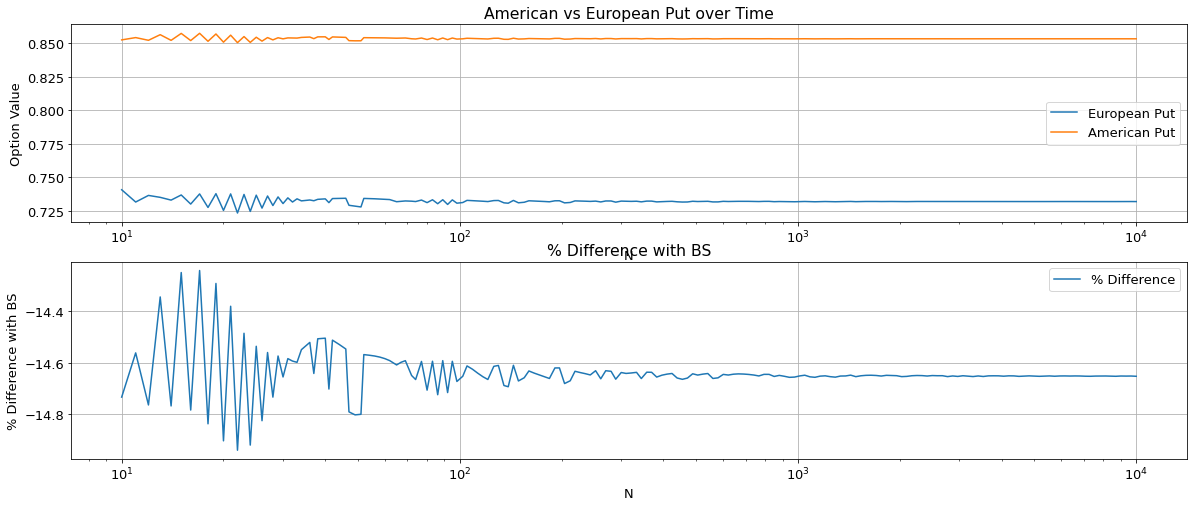

In [348]:
_results_df = pd.DataFrame(values[:, 1:], columns=['European Put', 'American Put'] , index=values[:, 0]).sort_index()
_results_df["% Difference"] = (_results_df[['American Put']].to_numpy() - _results_df[['European Put']].to_numpy() / _results_df[['European Put']].to_numpy()) * 100

fig, axs = plt.subplots(2)

_results_df[['European Put', 'American Put']].plot(figsize=(20,8), xlabel='N', ylabel='Option Value', ax=axs[0],
                              title='American vs European Put over Time', grid=True, logx=True)
_results_df[["% Difference"]].plot(figsize=(20,8), xlabel='N', ylabel='% Difference with BS',  ax=axs[1],
                              title='% Difference with BS', grid=True, logx=True)
_results_df.iloc[-1]

## Difference in value between European and American Puts

In [349]:
N = 20_000
european = option_valuation_bt(T, r , K, rs_vol2, N, S0, type="P")
american = option_valuation_bt(T, r , K, rs_vol2, N, S0, type="P", american=True)

print(f'European Put Value = {european:.5f} USD')
print(f'American Put Value = {american:.5f} USD')
print(f'Difference = {american - european:.5f} USD or {(american - european)/american * 100:.2f} %')

European Put Value = 0.73198 USD
American Put Value = 0.85348 USD
Difference = 0.12150 USD or 14.24 %


In [350]:
N = 100
size = 100  ;   values = np.zeros((size, 3))
for _r in tqdm(np.linspace(-2, 5, num=size)): #  _starting_n, NN)):
    _r = np.log(1+ _r/100) # From annual to CCIR
    _V_bt_european = option_valuation_bt(T, _r , K, rs_vol2, N, S0, type="P")
    _V_bt_american = option_valuation_bt(T, _r , K, rs_vol2, N, S0, type="P", american=True)
    values[size-1] = [_r, _V_bt_european, _V_bt_american]
    size -= 1
values = values[::-1]
# values[1:] = np.maximum(values[1:], 0.)
values

100%|██████████| 100/100 [00:00<00:00, 7656.35it/s]


array([[-2.02027073e-02,  2.48302995e+00,  2.48302995e+00],
       [-1.94814668e-02,  2.42573149e+00,  2.42573149e+00],
       [-1.87607460e-02,  2.36883085e+00,  2.36883085e+00],
       [-1.80405443e-02,  2.31234432e+00,  2.31234432e+00],
       [-1.73208609e-02,  2.25628848e+00,  2.25628848e+00],
       [-1.66016951e-02,  2.20068021e+00,  2.20068021e+00],
       [-1.58830462e-02,  2.14553662e+00,  2.14553662e+00],
       [-1.51649133e-02,  2.09087505e+00,  2.09087505e+00],
       [-1.44472957e-02,  2.03671299e+00,  2.03671299e+00],
       [-1.37301928e-02,  1.98306808e+00,  1.98306808e+00],
       [-1.30136037e-02,  1.92995804e+00,  1.92995804e+00],
       [-1.22975278e-02,  1.87740064e+00,  1.87740064e+00],
       [-1.15819643e-02,  1.82541366e+00,  1.82541366e+00],
       [-1.08669124e-02,  1.77401484e+00,  1.77401484e+00],
       [-1.01523715e-02,  1.72322180e+00,  1.72322180e+00],
       [-9.43834073e-03,  1.67305204e+00,  1.67305204e+00],
       [-8.72481947e-03,  1.62352287e+00

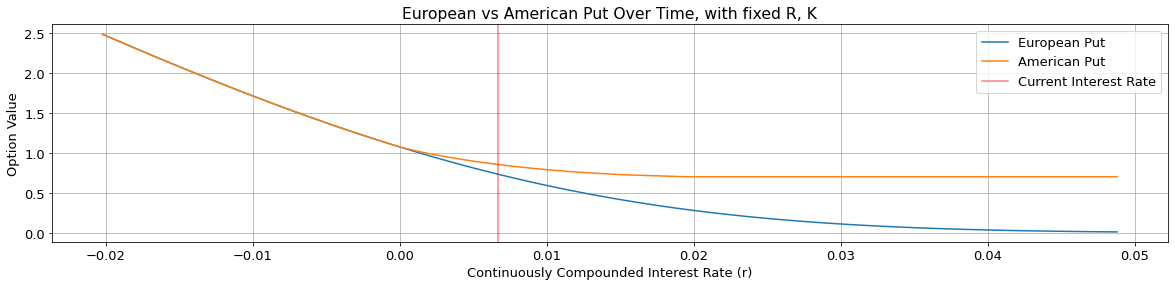

In [351]:
_results_df = pd.DataFrame(values[:, 1:], columns=['European Put', 'American Put'] , index=values[:, 0]).sort_index()

""" Plot """
axs = _results_df[['European Put', 'American Put']].plot(figsize=(20,4), xlabel='Continuously Compounded Interest Rate (r)', ylabel='Option Value',
                              title='European vs American Put Over Time, with fixed R, K', grid=True)
axs.axvline(r, color='r', linestyle='-', alpha=.5, label='Current Interest Rate') ;   axs.legend()


## Calculate Implied Volatility
Using the bump and revalue gradient algorithm

### Calculate Expected Difference with European Put Using Analytical Solution for European Put

In [352]:
def calculate_SE():
    size = 11   ;   _N = 2_000
    _results_se = np.empty((size, 3))  ;   index = 0
    for _coef in np.linspace(-1, 1, num=size):
        _sigma = realized_volatility_last_6_months * (10**_coef)
        _results_se[index, 0] = _sigma
        _results_se[index, 1] = _coef
        _results_se[index, 2] = (option_valuation_bt(T, r, K, _sigma, n, S0, type="P", american=True) - bs_put(S0, K, T, r, _sigma))/bs_put(S0, K, T, r, _sigma)*100
        index += 1
    return _results_se
_results_se = calculate_SE()
_results_se

array([[ 1.62094613e-03, -1.00000000e+00,  3.45875516e+02],
       [ 2.56902649e-03, -8.00000000e-01,  2.59177103e+02],
       [ 4.07163260e-03, -6.00000000e-01,  1.68666578e+02],
       [ 6.45310279e-03, -4.00000000e-01,  9.00224624e+01],
       [ 1.02274787e-02, -2.00000000e-01,  3.31754615e+01],
       [ 1.62094613e-02,  0.00000000e+00,  1.32568290e+01],
       [ 2.56902649e-02,  2.00000000e-01,  6.11776749e+00],
       [ 4.07163260e-02,  4.00000000e-01,  3.06446077e+00],
       [ 6.45310279e-02,  6.00000000e-01,  1.61999488e+00],
       [ 1.02274787e-01,  8.00000000e-01,  8.89540052e-01],
       [ 1.62094613e-01,  1.00000000e+00,  5.08290773e-01]])

([<matplotlib.axis.XTick at 0x1403c9f90>,
 [Text(-1.0, 0, '0.00162'),
  Text(-0.75, 0, '0.00288'),
  Text(-0.5, 0, '0.00513'),
  Text(-0.25, 0, '0.00912'),
  Text(0.0, 0, '0.01621'),
  Text(0.25, 0, '0.02882'),
  Text(0.5, 0, '0.05126'),
  Text(0.75, 0, '0.09115'),
  Text(1.0, 0, '0.16209')])

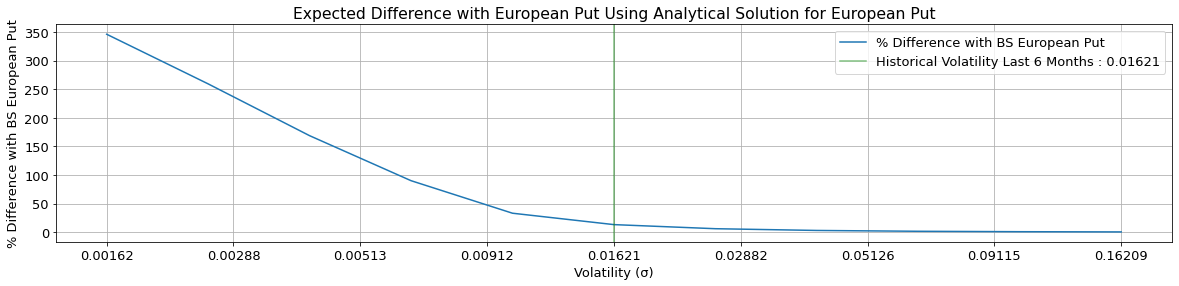

In [353]:
_results_se_df = pd.DataFrame(_results_se[:, 1:], columns=['Volatility (σ)','% Difference with BS European Put'])
_results_se_df.set_index("Volatility (σ)", inplace=True)

ax = _results_se_df.plot(figsize=(20,4), grid=True, ylabel='% Difference with BS European Put', title="Expected Difference with European Put Using Analytical Solution for European Put")
ax.axvline(0, color='g', linestyle='-', alpha=.5, label=f'Historical Volatility Last 6 Months : {realized_volatility_last_6_months:.5f}')
ax.legend()

plt.xticks(plt.xticks()[0][1:-1], [f'{realized_volatility_last_6_months * (10**x):.5f}' for x in plt.xticks()[0][1:-1]])

In [363]:
""" Choice Number of Steps """
print('-------- Number of steps --------')
print(_results_convergence_df[_results_convergence_df.index > 1000].index.values)

-------- Number of steps --------
[ 1072  1149  1232  1321  1417  1519  1629  1747  1873  2009  2154  2310
  2477  2656  2848  3053  3274  3511  3764  4037  4328  4641  4977  5336
  5722  6135  6579  7054  7564  8111  8697  9326 10000]


In [364]:
N = 2009
SE = _results_convergence_df[_results_convergence_df.index == N][["|Difference|"]].values[0,0]
SE

4.079903871545554e-05

In [366]:
epsilon = 0.0001
s0 = realized_volatility_last_6_months
print(f"Correct Option Value = {P0}")

_P0 = option_valuation_bt(T, r, K, s0, N, S0, type="P", american=True)  ;   runs = 0    ;   _iv_convergence = [s0]
print(f"difference in P0 estimation = {_P0 - P0}")
while True:
    runs += 1  # ; print("|", end="")
    """ step 1: calculate new Option Values """
    _Pt = option_valuation_bt(T, r, K, s0+epsilon, N, S0, type="P", american=True)
    print(f'Pt = {_Pt}')

    """ step 2: Calculate new delta between them """
    _D =  _P0 - _Pt  # if _P0 is larger that _Pt, delta has to be positive
    print(f'_D = {_D}')

    """ step 3: Estimate correct Delta """
    _Dc = P0 - _Pt  # if P0 is larger than _Pt, the delta_correct has to bo be positive
    print(f'_Dc = {_Dc}')

    """ step 4: Estimate new s0 based on Deltas' Ratio """
    s0 += - (_Dc / _D * epsilon)  # Adjusting the rate of change for
    _iv_convergence.append(s0)
    print(f's0 = {s0}')

    """ step 5: Calculate if the approximation is within the SE """
    _P0 = option_valuation_bt(T, r, K, s0, N, S0, type="P", american=True)

    print(f">>> Difference in P0 estimation = {_P0 - P0} \n\n")
    # if runs > 2 : break

    if abs(_P0 - P0) < SE : break
    epsilon /= 10

s_implied = s0  ;   print(f'Implied Volatility = {s_implied:.5f}  vs  Historical Volatility = {realized_volatility_last_6_months:.5f}'
                          f'  :  Difference = {(s_implied - realized_volatility_last_6_months)/realized_volatility_last_6_months * 100 :.3f} %  \n>>> Iterations = {runs}')

Correct Option Value = 3.15
difference in P0 estimation = -2.2235433090644134
Pt = 0.9305044369376838
_D = -0.004047746002097563
_Dc = 2.219495563062316
s0 = 0.07104233774580133
>>> Difference in P0 estimation = 0.2566237631907802 


Pt = 3.407084786493924
_D = -0.0004610233031439037
_Dc = -0.2570847864939241
s0 = 0.06546594313102244
>>> Difference in P0 estimation = -0.0004305276624134713 


Pt = 3.1496155627265714
_D = -4.609038898495399e-05
_Dc = 0.0003844372734285173
s0 = 0.065474284073286
>>> Difference in P0 estimation = -4.6090638225582126e-05 


Pt = 3.149958518393493
_D = -4.609031718505463e-06
_Dc = 4.148160650707666e-05
s0 = 0.06547518408025146
>>> Difference in P0 estimation = -4.609021557744342e-06 


Implied Volatility = 0.06548  vs  Historical Volatility = 0.01621  :  Difference = 303.932 %  
>>> Iterations = 4


In [367]:
_iv_convergence

[0.016209461327365938,
 0.07104233774580133,
 0.06546594313102244,
 0.065474284073286,
 0.06547518408025146]